In [ ]:
# UNCOMMENT AND RUN IF IN COLAB
# ! git clone https://github.com/AllenCell/i2k_workshop_2024.git
# %cd i2k_workshop_2024
# ! pip install -r requirements.txt

## Download models (colab)

In [ ]:
contrastive_model_path = 'https://github.com/AllenCell/i2k_workshop_2024/releases/download/v0.1/contrastive_predict.ckpt'
instance_seg_model_path = 'https://github.com/AllenCell/i2k_workshop_2024/releases/download/v0.1/instance_seg_predict.ckpt'

# Change this to the i2k_workshop_2024/assets/models folder if not on colab
dest_path = '/content/i2k_workshop_2024/assets/models' 
! wget -P $dest_path $contrastive_model_path
! wget -P $dest_path $instance_seg_model_path

# I2K Workshop 2024

This hands-on workshop will introduce you to CytoDL, a powerful deep learning framework developed by the Allen Institute for Cell Science. CytoDL is designed to streamline the analysis of biological images, including 2D and 3D data represented as images, point clouds, and tabular formats.
You will learn how to leverage CytoDL to:

A. Get single cell and nucleus instance segmentations from image datasets from the Allen Institute from Cell Science [1]

B. Use the single cell images from (A) to extract unsupervised features to detect morphological perturbations of intracellular structures [1].

[1] - Donovan-Maiye, Rory M., et al. "A deep generative model of 3D single-cell organization." PLOS Computational Biology 18.1 (2022): e1009155.


## What is CytoDL?

CytoDL is a python-based package that aims to make deep-learning based microscopy image analysis projects modular, maintainable, and reproducible​ by
​
1. Identifying common structural components​ of these projects​,
2. Providing new components and making incorporation of open-source components easy, and  ​
3. Providing recipes for combining custom and open source components​
​

Using the configurability of [hydra](https://hydra.cc/), CytoDL allows users to easily switch between different models, datasets, and training configurations. CytoDL also provides a set of project templates to quickly train 2D and 3D models for in-silico labeling, semantic and instance segmentation, classification, contrastive learning, and masked image modeling. To better understand the capabilities of CytoDL, let's first examine the configuration file for a single experiment training an instance segmentation model. 

CytoDL models are most commonly used from the CLI, for the sake of this notebook we will use the API (in beta) to showcase its programmatic use. 

First, we will load a model from its configuration file.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'MIG-8f3b2a99-4e01-5b69-8b78-dbd3c9fe2a83'

In [3]:
from cyto_dl.api import CytoDLModel
from pathlib import Path
WORKING_DIR = Path.cwd()

model = CytoDLModel()
model.load_config_from_file(WORKING_DIR/'configs/instance_seg_train.yaml')

### Quick intro to hydra and omegaconf
[hydra](https://hydra.cc) and [omegaconf](https://omegaconf.readthedocs.io/en/2.3_branch/) provide the flexibility underlying the configuration files in CytoDL. There are two important pieces of syntax to understand.

1. `_target_` 

In the configuration file, `_target_` is used to specify the class that will be instantiated. All arguments underneath `_target_` will be passed to the class constructor. So in a config, 
```yaml
_target_: numpy.array
object: [1,2,3]
```   
is equivalent to the python code
```python
numpy.array(object=[1,2,3])
```

2. OmegaConf interpolation `${}`

OmegaConf allows for interpolation of variables in the configuration file. For example, if you have a variable `path: /path/to/data`, you can use `${path}` to refer to the value of `path`. If a variable is used in the `experiment` config, it can be accessed without a prefix, but if it is located in the `data`, `model`, or other config, it must be accessed like `${data.var}`, `${model.var}` etc.

Models can be loaded by their configuration files, from a dictionary, or from one of the provided templates. When loading the configuration, overrides can be provided to change the configuration parameters.

### Data Config
First, let's examine the data configuration. Here, we specify a training and validation dataloader that takes in numpy arrays and performs a sequence of transforms on them to normalize the raw input data and transform the segmentation images into an appropriate format for model training. Notice that each python object (the dataloader and transforms) that will ultimately be used in training is specified in the config using the hydra `_target_` syntax to specify the function and its arguments to be instantiated. This results in flexibility and reproducibility - configurations uniquely specify the data pipeline used and allows easy interchangeability of transforms (e.g. from CytoDL, monai, pytorch, etc.). The OmegaConf interpolation syntax (`${variable}`) is also used to create consistency within and between configuration files. CytoDL also provides utilities for common microscopy data formats and datamodules for loading datasets specified by file paths or folders instead of raw numpy arrays

In [4]:
from cyto_dl.utils.rich_utils import print_config_tree
print_config_tree(model.cfg.data, print_order=[])

CONFIG
├── _aux
│   └── patch_shape:                                                                                               
│       - 16                                                                                                       
│       - 16                                                                                                       
│       - 16                                                                                                       
│                                                                                                                  
├── train_dataloaders
│   └── _target_: cyto_dl.datamodules.array.make_array_dataloader                                                  
│       data: null                                                                                                 
│       num_workers: 1                                                                                             
│       batch_size: 1                                                                                              
│       source_key: ${source_col}                                                                                  
│       transforms:                                                                                                
│       - _target_: monai.transforms.ToTensord                                                                     
│         keys:                                                                                                    
│         - raw                                                                                                    
│         - seg                                                                                                    
│         dtype: float32                                                                                           
│       - _target_: cyto_dl.image.transforms.clip.Clipd                                                            
│         keys: raw                                                                                                
│       - _target_: monai.transforms.NormalizeIntensityd                                                           
│         keys: raw                                                                                                
│         channel_wise: true                                                                                       
│       - _target_: cyto_dl.models.im2im.utils.instance_seg.InstanceSegPreprocessd                                 
│         label_keys:                                                                                              
│         - seg                                                                                                    
│         dim: 3                                                                                                   
│         anisotropy: 2.6                                                                                          
│         thin: 10                                                                                                 
│       - _target_: monai.transforms.RandSpatialCropSamplesd                                                       
│         keys:                                                                                                    
│         - raw                                                                                                    
│         - seg                                                                                                    
│         roi_size: ${data._aux.patch_shape}                                                                       
│         random_size: false                                                                                       
│         num_samples: 1                                                                                           
│       - _target_

### Model Config


In the model config, we specify how data flows through our project to create a trained model. Here, we use the `MultiTaskIm2Im` class, which creates models with a shared backbone and then (optionally multiple) task-specific heads that take shared backbone features as input. In this case, we have a single task head for instance segmentation, which performs additional convolution on the backbone features to create a 6-channel output (we'll dig into what this looks like in a minute) and is optimized with a custom loss function. 
Optimization parameters like learning rate schedulers are also provided in the model config.

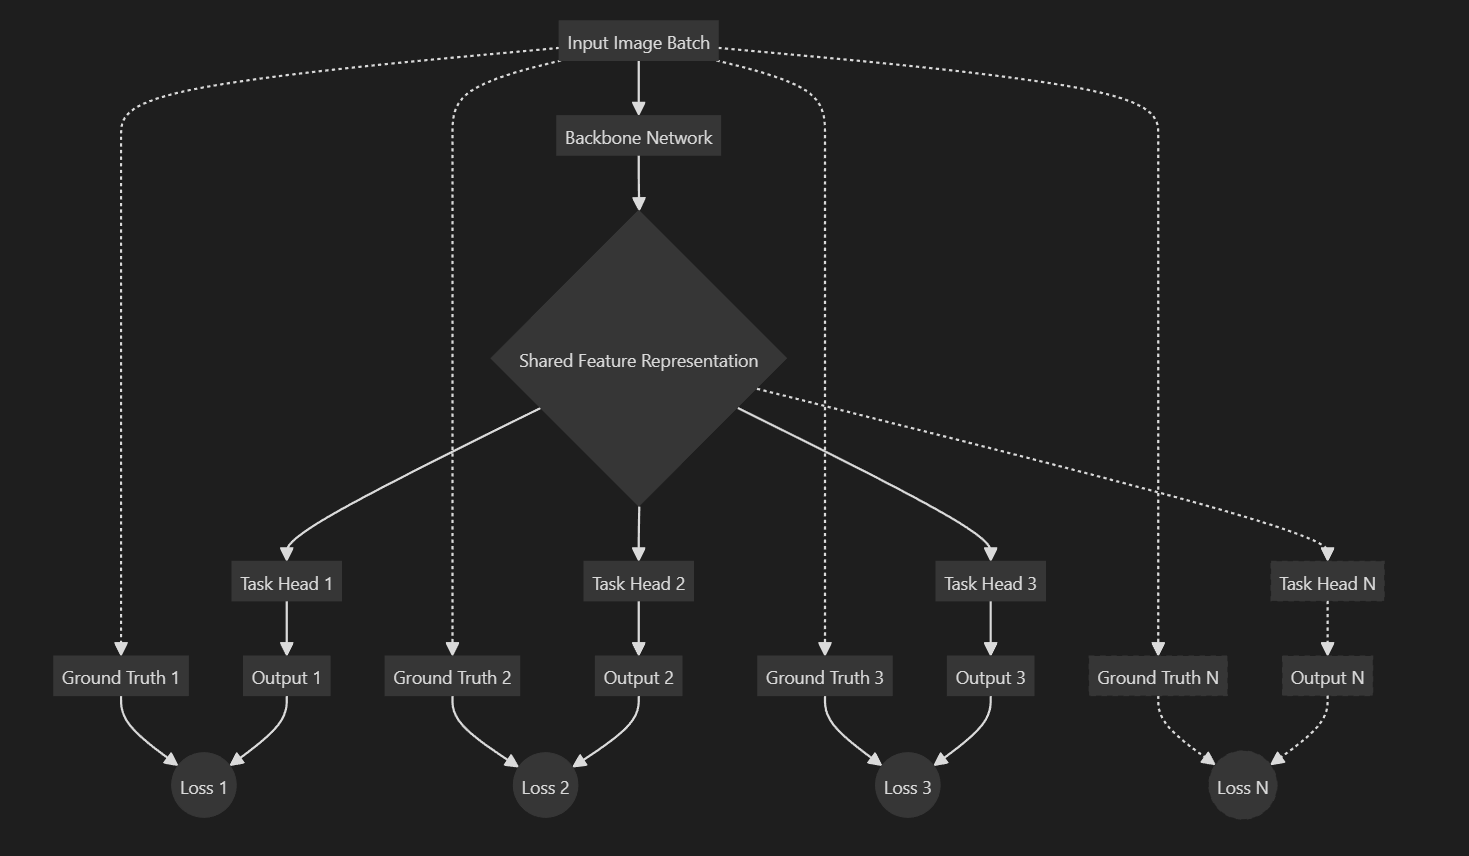

In [3]:
print_config_tree(model.cfg.model, print_order=[])

CONFIG
├── _target_
│   └── cyto_dl.models.im2im.MultiTaskIm2Im                                                                        
├── compile
│   └── False                                                                                                      
├── save_images_every_n_epochs
│   └── 1                                                                                                          
├── x_key
│   └── raw                                                                                                        
├── save_dir
│   └── None                                                                                                       
├── backbone
│   └── _target_: monai.networks.nets.DynUNet                                                                      
│       spatial_dims: 3                                                                                            
│       in_channels: 1                                                                                             
│       out_channels: ${model._aux.out_channels}                                                                   
│       strides:                                                                                                   
│       - 1                                                                                                        
│       - 2                                                                                                        
│       - 2                                                                                                        
│       - 2                                                                                                        
│       kernel_size:                                                                                               
│       - 3                                                                                                        
│       - 3                                                                                                        
│       - 3                                                                                                        
│       - 3                                                                                                        
│       upsample_kernel_size:                                                                                      
│       - 2                                                                                                        
│       - 2                                                                                                        
│       - 2                                                                                                        
│       filters:                                                                                                   
│       - 16                                                                                                       
│       - 32                                                                                                       
│       - 64                                                                                                       
│       - 128                                                                                                      
│       dropout: 0.0                                                                                               
│       res_block: true                                                                                            
│                                                                                                                  
├── task_heads
│   └── seg:                                                                                                       
│         _target_: cyto_dl.nn.ResBlocksHead                                                                       
│         in_channels: ${model._aux.out_channels}         

### Trainer Config
We use PyTorch Lightning for training, which allows us to specify the training loop in a modular way. The trainer config specifies the number of epochs, the number of GPUs to use, and other training parameters.

In [4]:
print_config_tree(model.cfg.trainer, print_order=[])

CONFIG
├── _target_
│   └── lightning.Trainer                                                                                          
├── default_root_dir
│   └── None                                                                                                       
├── min_epochs
│   └── 1                                                                                                          
├── max_epochs
│   └── 100                                                                                                        
├── accelerator
│   └── cpu                                                                                                        
├── devices
│   └── 1                                                                                                          
├── precision
│   └── 16                                                                                                         
├── check_val_every_n_epoch
│   └── 10                                                                                                         
├── deterministic
│   └── False                                                                                                      
├── detect_anomaly
│   └── False                                                                                                      
└── max_time
    └── None                                                                                                       

### Experiment Config
The experiment config composes each of the above configurations (as well as configurations for callbacks, loggers, saving paths, and other parameters) to create a full training pipeline. This is the configuration file that is passed to the `train` function to start training. This modularity (plus the ability to override parameters from the command line or the experiment config) makes it easy to experiment with different models, data, and training parameters.

With a basic understanding of CytoDL established, let's dive into our single cell dataset and then train a model!

## Single Cell Dataset Creation


### Training a Cell Instance Segmentation Model
We will use the dataset from [1] to train a cell instance segmentation model using CytoDL for application on our drug perturbation dataset. 


1. Downloading the dataset

In [5]:
import quilt3
import tqdm
import pandas as pd

def download_dataset(save_path, n_subsample=1):
    # set up save directories
    raw_path = Path(save_path)
    (raw_path/'raw').mkdir(parents=True, exist_ok=True)
    (raw_path/'seg').mkdir(parents=True, exist_ok=True)

    local_sample_path = WORKING_DIR/'local_data'/'meta.csv'
    # connect to quilt
    pkg = quilt3.Package.browse("aics/hipsc_single_cell_image_dataset", registry="s3://allencell")

    try: 
        meta_df = pd.read_csv(local_sample_path)
    except FileNotFoundError:
        meta_df = pkg["metadata.csv"]().sample(n=n_subsample)
        meta_df.to_csv(local_sample_path)

    for row in tqdm.tqdm(meta_df.itertuples(), desc="Downloading images"):
        # get raw images
        subdir_name = row.fov_path.split("/")[0]
        file_name = row.fov_path.split("/")[1]
        local_fn = raw_path / 'raw' / f"{row.FOVId}.tiff"
        pkg[subdir_name][file_name].fetch(local_fn)

        # get segmentation masks
        subdir_name = row.fov_seg_path.split("/")[0]
        file_name = row.fov_seg_path.split("/")[1]
        local_fn = raw_path / 'seg' / f"{row.FOVId}.tiff"
        pkg[subdir_name][file_name].fetch(local_fn)

In [17]:
download_dataset(WORKING_DIR/'local_data', n_subsample=10)

Loading manifest: 100%|██████████| 484465/484465 [00:11<00:00, 40.6k/s]
100%|██████████| 378M/378M [00:09<00:00, 41.4MB/s]
100%|██████████| 1.01M/1.01M [00:00<00:00, 1.03MB/s]
100%|██████████| 179M/179M [00:09<00:00, 19.8MB/s]
100%|██████████| 1.23M/1.23M [00:03<00:00, 385kB/s]
100%|██████████| 222M/222M [00:02<00:00, 84.8MB/s]
100%|██████████| 1.06M/1.06M [00:00<00:00, 1.06MB/s]
100%|██████████| 386M/386M [00:08<00:00, 44.4MB/s]
100%|██████████| 1.07M/1.07M [00:00<00:00, 1.18MB/s]
100%|██████████| 193M/193M [00:08<00:00, 22.0MB/s]
100%|██████████| 1.45M/1.45M [00:00<00:00, 1.47MB/s]
100%|██████████| 403M/403M [00:08<00:00, 45.2MB/s]
100%|██████████| 1.57M/1.57M [00:01<00:00, 1.51MB/s]
100%|██████████| 353M/353M [00:09<00:00, 38.8MB/s]
100%|██████████| 1.14M/1.14M [00:01<00:00, 1.12MB/s]
100%|██████████| 377M/377M [00:09<00:00, 41.3MB/s]
100%|██████████| 1.16M/1.16M [00:01<00:00, 1.07MB/s]
100%|██████████| 441M/441M [00:08<00:00, 49.0MB/s]
100%|██████████| 2.21M/2.21M [00:01<00:00, 1.9

2. Visualizing Instance Segmentation

Inspired by methods like CellPose, Omnipose, and SKOOTS, CytoDL implements a vector-field based approach to instance segmentation. This approach is particularly useful for segmenting cells that are touching or overlapping. This type of model predicts 6 channels:

[1] A connectivity-preserving erosion that forms the "core" of each object

[2] A semantic segmentation generated by thresholding the instance segmentation

[3-6] ZYX vector fields that predict the direction to the nearest object boundary from channel 1 in each direction 

During postprocessing, we use the Ch.2 to identify foreground pixels and then split objects using the vector fields and a connected component labeling of Ch. 1. 

##### References
1. Cellpose3: one-click image restoration for improved cellular segmentation. Carsen Stringer, Marius Pachitariu. bioRxiv 2024.02.10.579780; doi: https://doi.org/10.1101/2024.02.10.579780
2. Cutler, K.J., Stringer, C., Lo, T.W. et al. Omnipose: a high-precision morphology-independent solution for bacterial cell segmentation. Nat Methods 19, 1438–1448 (2022). https://doi.org/10.1038/s41592-022-01639-4
3. SKOOTS: Skeleton oriented object segmentation for mitochondria. Christopher J Buswinka, Hidetomi Nitta, Richard T. Osgood, Artur A. Indzhykulian. bioRxiv 2023.05.05.539611; doi: https://doi.org/10.1101/2023.05.05.539611

In [6]:
from bioio import BioImage
from cyto_dl.models.im2im.utils.instance_seg import InstanceSegPreprocessd
import numpy as np
import torch
import matplotlib.pyplot as plt


def load(fn, C):
    return BioImage(fn).get_image_dask_data('ZYX', C=C).compute()

def load_cell_seg(fn):
    return load(fn, 1)

def load_structure(fn):
    img = BioImage(fn)
    n_channels = len(img.channel_names)
    if n_channels == 7:
        ch = 3
    elif n_channels == 4:
        ch = 1
    return load(fn, ch)

def load_membrane(fn):
    img = BioImage(fn)
    n_channels = len(img.channel_names)
    if n_channels == 7:
        ch = 1
    elif n_channels == 4:
        ch = 2
    return load(fn, ch)

def generate_gt(seg):
    preprocess = InstanceSegPreprocessd(label_keys='seg')
    # ignore costmap
    seg = preprocess({'seg':torch.from_numpy(seg)})['seg'][:-1]
    return seg

def select_full_cell(seg):
    cells = set(np.unique(seg))
    cells.remove(0)
    border_mask = np.ones_like(seg).astype(bool)
    border_mask[1:-1,1:-1, 1:-1] = False
    border_cellids = set(np.unique(seg[border_mask]))
    full_cells = list(cells - border_cellids)
    return np.random.choice(full_cells, size=1)[0]

def crop_to_cell(img, buffer=10):
    best_z = np.argmax(np.sum(img[2], axis=(1,2)))
    img =img[:, best_z]
    cell_coords = np.where(img[2])

    x_min = max(0, cell_coords[0].min()-buffer)
    x_max = min(img.shape[1], cell_coords[0].max()+buffer)
    y_min = max(0, cell_coords[1].min()-buffer)
    y_max = min(img.shape[2], cell_coords[1].max()+buffer)

    return img[:, x_min:x_max, y_min:y_max]

def extract_example():
    # select random example
    files = list((WORKING_DIR / 'local_data/raw').iterdir())
    example_fn = np.random.choice(files)
    # load images
    raw = load_membrane(example_fn)
    seg = load_cell_seg(str(example_fn).replace('raw','seg'))
    print('Example images loaded')
    # visualize a random cell
    cell_id = select_full_cell(seg)
    # generate ground truth for model training
    multich_gt = generate_gt(seg==cell_id)
    print("Instance segmentation ground truth generated")
    combined_image = np.concatenate([raw[None],multich_gt], axis=0)
    combined_image= crop_to_cell(combined_image)
    return combined_image

def visualize_example(example):
    fig, ax = plt.subplots(1, example.shape[0], figsize=(30, 10))

    channel_names = ['Membrane', 'Connectivity Preserving Erosion', 'Semantic Segmentation', 'Z Gradient', 'Y Gradient', 'X Gradient', 'Boundary Segmentation']
    for i in range(example.shape[0]):
        ax[i].imshow(example[i], cmap='viridis')
        ax[i].axis('off')
        ax[i].set_title(channel_names[i])

Example images loaded
Instance segmentation ground truth generated


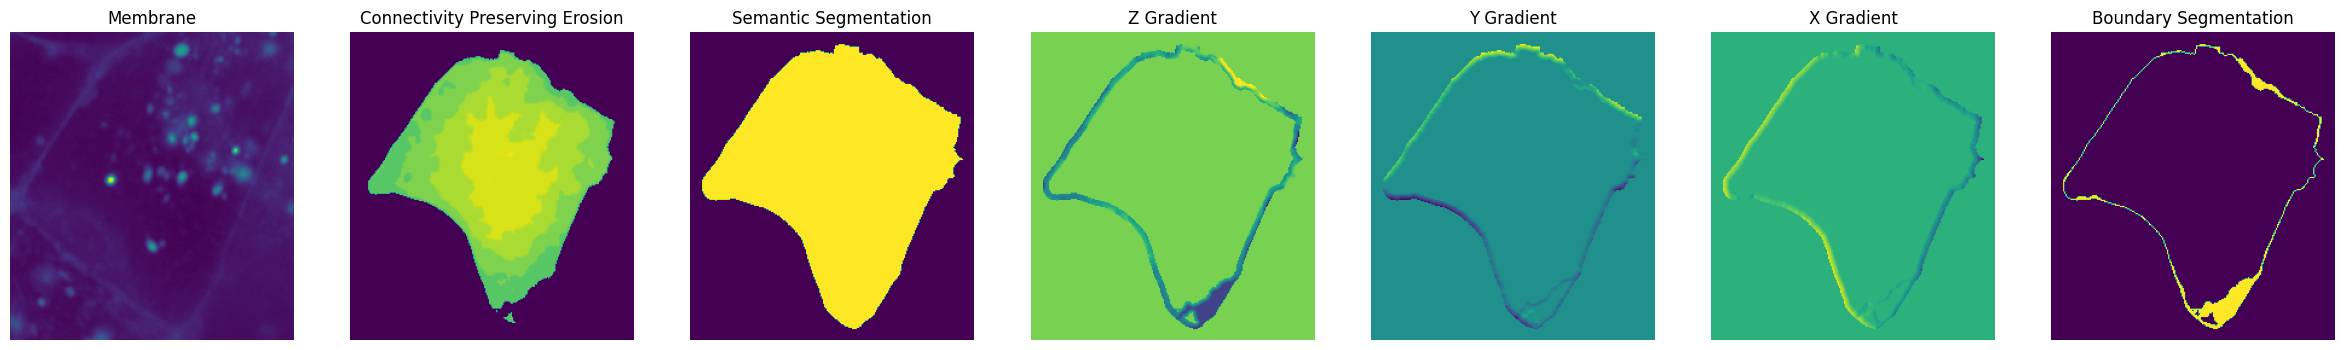

In [16]:
example = extract_example()
visualize_example(example)

3. Model training

Now that we have a few examples of the dataset downloaded and we understand the format of the instance segmentation ground truth, we can start model training. To keep things quick, we'll just train for 1 epoch. In practice, you would want to train for many more epochs. Notice how we can provide overrides to the training function to allow programmatic manipulation of the configuration.

In [7]:
# train instance seg model
from cyto_dl.api import CytoDLModel
from sklearn.model_selection import train_test_split
import tqdm


def load_dataset():
    """
    Load small dataset for quick training
    """
    raw = []
    seg = []
    for raw_fn, seg_fn in tqdm.tqdm(zip((WORKING_DIR / 'local_data/raw').iterdir(), (WORKING_DIR / 'local_data/seg').iterdir()), desc='Loading dataset'):
        # load and add channel dimension
        raw.append(load_membrane(raw_fn)[None])
        seg.append(load_cell_seg(seg_fn)[None])

        if len(raw) == 3:
            break

    raw_train, raw_val, seg_train,  seg_val = train_test_split(raw, seg, test_size=1)
    train_data = [{'raw': rt, 'seg': st} for rt, st in zip(raw_train, seg_train)]
    val_data = [{'raw': rv, 'seg': sv} for rv, sv in zip(raw_val, seg_val)]
    return {
        'train': train_data,
        'val': val_data
    }

def train_model(cfg_path:str,  dataset, overrides={}):
    # load model
    model = CytoDLModel()
    model.load_config_from_file(cfg_path)

    # apply overrides
    model.override_config(overrides)

    Path(model.cfg.paths.output_dir).mkdir(parents=True, exist_ok=True)

    # apply model
    model.train(data=dataset)

In [ ]:
data = load_dataset()
# switch to the cpu trainer if a GPU isn't available
overrides = overrides={'trainer.max_epochs':1, "paths.output_dir": WORKING_DIR/'local_data'/'instance_seg_train'}
if not torch.cuda.is_available():
    overrides['trainer.accelerator'] = 'cpu'
    overrides['trainer.devices'] = 1  
train_model(WORKING_DIR/'configs/instance_seg_train.yaml', dataset=data, overrides=overrides)

### Dataset Creation

Now that we have the trained model (here we'll use a pretrained one instead of the one we just trained for a single epoch), we will use it to create a dataset of single cell images from the drug perturbed and non-perturbed datasets.

First, we will generate FOV-level instance segmentations. 

In [24]:
data[0].shape

(1, 70, 624, 924)

Example images loaded


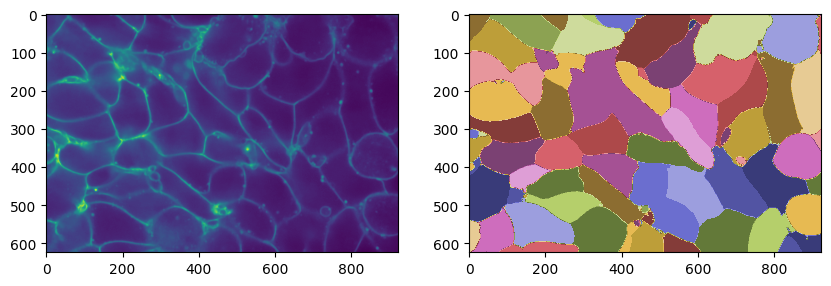

: 

In [57]:
from cyto_dl.utils import extract_array_predictions
import matplotlib.pyplot as plt

# apply instance seg model
def apply_instance_seg_model(cfg_path:str,  data, overrides={}):
    # load model
    model = CytoDLModel()
    model.load_config_from_file(cfg_path)

    # apply overrides
    model.override_config(overrides)

    output_path = model.cfg.paths.output_dir
    Path(output_path).mkdir(parents=True, exist_ok=True)

    # apply model
    _, _, output = model.predict(data=data)
    print('Model prediction finished.')
    preds = extract_array_predictions(output)
    return preds

raw_fn = list((WORKING_DIR / 'local_data/raw').iterdir())[-1]
data = [load_membrane(raw_fn)[None]]
print('Example images loaded')

pred = apply_instance_seg_model(WORKING_DIR/'configs'/'instance_seg_predict.yaml', data, overrides={'paths.output_dir': str(WORKING_DIR/'local_data/instance_seg_apply')})


fig, ax= plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(data[0].squeeze()[30])
ax[1].imshow(pred['fov_seg'].squeeze()[30]%20, cmap='tab20b')

# raw predictions
# ax[1].imshow(pred['fov_seg'][0][0][30])

We can then use these segmentations to extract single cell images from the FOVs and normalize their intensities. We exclude cells that are too small (likely noise from our segmentation model) or cells that touch the edge of the FOV, rotate them in the YX plane to align the major axis of the cell with the X axis, and crop them to a fixed size.

10it [00:07,  1.32it/s]


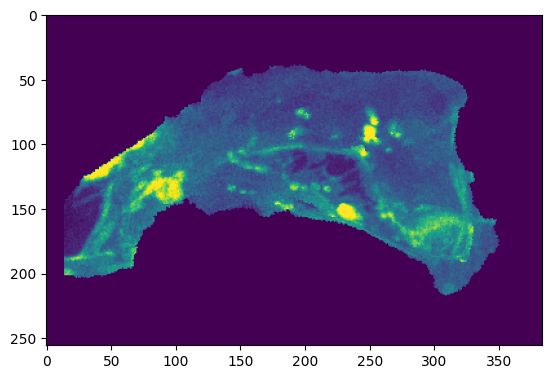

In [8]:
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops_table
import pandas as pd
import tqdm
from monai.transforms import SpatialCrop
from scipy.ndimage import binary_dilation
from aicsshparam import shtools


def remove_border(img):
    # remove instances touching the border
    mask = np.ones_like(img, dtype=bool)
    mask[1:-1, 1:-1, 1:-1] = False
    border_idxs = np.unique(img[mask])
    img[np.isin(img, border_idxs)] = 0
    return img

def normalize(img):
    # remove background
    img = img-np.median(img)
    # clip image values to 50-99.98 percentile
    max = np.percentile(img, 99.98)
    img[img>max] = max
    img[img<0] = 0
    # rescale to 0-255
    img = rescale_intensity(img, out_range=(0, 255))
    return img

def extract_single_cells(raw_fn, seg_fn, size_threshold=2e5, crop_size=[56, 256, 384]):
    raw = load_structure(raw_fn)
    raw = normalize(raw)

    seg = load_cell_seg(seg_fn)
    seg = remove_border(seg)
    
    props = pd.DataFrame(regionprops_table(seg, properties=('label', 'slice','area')))
    # remove small objects
    props = props[props['area'] > size_threshold]

    cells = []
    for i, row in tqdm.tqdm(props.iterrows()):
        crop = raw[row['slice']]

        seg_crop = seg[row['slice']] == row['label']
        seg_crop = binary_dilation(seg_crop, iterations=1)

        # find rotation to make longest axis vertical
        seg_crop, angle = shtools.align_image_2d(seg_crop)
        crop = shtools.rotate_image_2d(crop[None], angle, interpolation_order = 3)

        # center crop on seg_crop centroid
        z, y, x = np.where(seg_crop.squeeze())
        centroid = np.array([np.mean(z), np.mean(y), np.mean(x)])
        cropper= SpatialCrop(centroid, crop_size)

        # set background to -1
        crop[seg_crop ==0] = -1

        # ensure crop is smaller than crop_size
        crop = cropper(crop).squeeze()
        # pad evenly to crop_size
        padding= np.array(crop_size) - np.array(crop.shape)
        padding_left = padding//2
        padding_right = padding - padding_left
        crop = np.pad(crop, ((padding_left[0], padding_right[0]), (padding_left[1], padding_right[1]), (padding_left[2], padding_right[2])), mode='constant', constant_values=-1)
        cells.append(crop)
    return cells

raw_fn = list((WORKING_DIR/'local_data/raw/').glob('*'))[0]
seg_fn = list((WORKING_DIR/'local_data/seg/').glob('*'))[0]

single_cells = extract_single_cells(raw_fn, seg_fn)
plt.imshow(single_cells[0].max(0), cmap='viridis')
plt.grid(False)

## Feature Extraction and Applications for Perturbation Detection

With single cell images extracted from the drug perturbation and non-perturbed datasets, we can now use them to extract unsupervised features to detect morphological perturbations of intracellular structures.

### VICReg Training

[VICReg](https://arxiv.org/pdf/2105.04906) is a contrastive learning method that incoroporates three principles for learning meaningful representations:
1. Variance - within a batch, features should be diverse. This prevents representational collapse
2. Invariance - features should be invariant to transformations of the input
3. Covariance - latent features should be independent (i.e. diagonal covariance)

This method combines three loss functions to enforce these principles. 

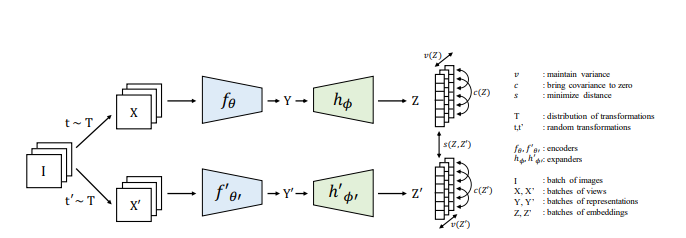

**Image from the VICReg paper**

The choice of augmentations to make learned features invariant to is highly domain-dependent and requires some experimentation. Here, we apply random flips, rotations, intensity shifts, Gaussian smoothing, and resizing on two copies of the same cell. We train on  *just* the non-drug treated dataset, and will then apply the trained model on a separate dataset containing drug- and vehicle-treated cells. This dataset is available for download [here](https://www.allencell.org/data-downloading.html#sectionDrugSignatureData). As this data is not easily available programmatically, all example training and inference will be done on the non-drug treated dataset.


### Data Config
Here, we implement a relatively complex data pipeline - we resize our single cell images to half resolution, create a copy of that image and augment each copy separately for contrastive learning.

In [19]:
model = CytoDLModel()
model.load_config_from_file(WORKING_DIR/'configs/contrastive_train.yaml')
print_config_tree(model.cfg.data, print_order=[])

CONFIG
├── train_dataloaders
│   └── _target_: cyto_dl.datamodules.array.make_array_dataloader                                                  
│       data: null                                                                                                 
│       batch_size: 128                                                                                            
│       num_workers: 16                                                                                            
│       transforms:                                                                                                
│       - _target_: monai.transforms.ToTensord                                                                     
│         keys:                                                                                                    
│         - input                                                                                                  
│         dtype: float16                                                                                           
│       - _target_: monai.transforms.Zoomd                                                                         
│         keys: input                                                                                              
│         zoom: 0.5                                                                                                
│         keep_size: false                                                                                         
│       - _target_: monai.transforms.CopyItemsd                                                                    
│         keys: input                                                                                              
│         times: 1                                                                                                 
│         names:                                                                                                   
│         - input_aug                                                                                              
│       - _target_: monai.transforms.RandFlipd                                                                     
│         keys:                                                                                                    
│         - input                                                                                                  
│         prob: 0.5                                                                                                
│         spatial_axis: 2                                                                                          
│       - _target_: monai.transforms.RandFlipd                                                                     
│         keys:                                                                                                    
│         - input                                                                                                  
│         prob: 0.5                                                                                                
│         spatial_axis: 1                                                                                          
│       - _target_: monai.transforms.RandZoomd                                                                     
│         keys:                                                                                                    
│         - input                                                                                                  
│         prob: 1.0                                                                                                
│         min_zoom: 0.8                                                                                            
│         max_zoom: 1.2                                                                                            
│       - _target_: monai.t

### Model Config
As opposed to the `MultiTaskIm2Im` model used for instance segmentation, our VICReg model uses a different data flow, where the two augmentations of our image (the "anchor" and "positive" images) are passed through the same backbone encoder (a series of convolutions and a linear layer to create a latent dimension of 256) to get their respective features. These features are then passed through a projection head (with dimension 1024) before calculating the contrastive loss. 

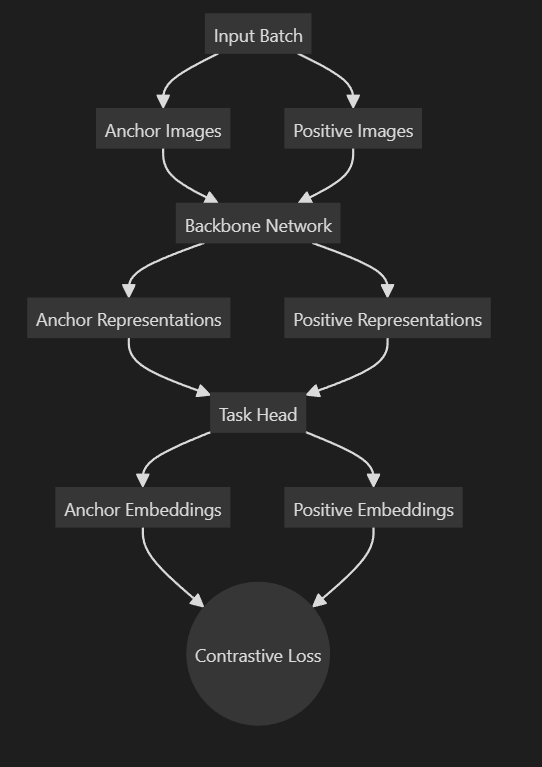

In [20]:
print_config_tree(model.cfg.model, print_order=[])

CONFIG
├── _target_
│   └── cyto_dl.models.contrastive.contrastive.Contrastive                                                         
├── save_dir
│   └── None                                                                                                       
├── anchor_key
│   └── input                                                                                                      
├── positive_key
│   └── input_aug                                                                                                  
├── backbone
│   └── _target_: monai.networks.nets.Regressor                                                                    
│       in_shape:                                                                                                  
│       - 1                                                                                                        
│       - 28                                                                                                       
│       - 128                                                                                                      
│       - 192                                                                                                      
│       out_shape: 256                                                                                             
│       channels:                                                                                                  
│       - 32                                                                                                       
│       - 64                                                                                                       
│       - 128                                                                                                      
│       - 256                                                                                                      
│       strides:                                                                                                   
│       - 2                                                                                                        
│       - 2                                                                                                        
│       - 2                                                                                                        
│       - 2                                                                                                        
│       kernel_size: 3                                                                                             
│                                                                                                                  
├── task_head
│   └── _target_: cyto_dl.nn.head.vic_reg.VICRegHead                                                               
│       loss:                                                                                                      
│         _target_: cyto_dl.nn.losses.vic_reg.VICRegLoss                                                           
│         num_features: 256                                                                                        
│       dims:                                                                                                      
│       - 256                                                                                                      
│       - 1024                                                                                                     
│       hidden_layers:                                                                                             
│       - 1024                                                                                                     
│       - 1024                                                                                                     
│       - 1024                                                                  

In [16]:
### Model Training
data = {
    'train': [{'input': cell[None]} for cell in single_cells[:-2]],
    'val': [{'input': cell[None]} for cell in single_cells[-2:]]
}
    
train_model(WORKING_DIR/'configs/contrastive_train.yaml', dataset=data, overrides={'trainer.max_epochs':10, "paths.output_dir": str(WORKING_DIR/'local_data'/'contrastive_train'), 'data.batch_size': 8})

['dev']

Seed set to 12345
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-8f3b2a99-4e01-5b69-8b78-dbd3c9fe2a83]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                  ┃ Type           ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ train/loss                            │ MeanMetric     │      0 │ train │
│ 1  │ val/loss                              │ MeanMetric     │      0 │ train │
│ 2  │ test/loss                             │ MeanMetric     │      0 │ train │
│ 3  │ backbone                              │ Regressor      │ 17.3 M │ train │
│ 4  │ backbone.net                          │ Sequential     │  4.7 M │ train │
│ 5  │ backbone.net.layer_0                  │ ResidualUnit   │ 29.5 K │ train │
│ 6  │ backbone.net.layer_0.conv             │ Sequential     │ 28.6 K │ train │
│ 7  │ backbone.net.layer_0.conv.unit0       │ Convolution    │    897 │ train │
│ 8  │ backbone.net.layer_0.conv.unit0.conv  │ Conv3d         │    896 │ train │
│ 9  │ backbone.net.layer_0.conv.unit0.adn   │ ADN            │      1 │ train │
│ 10 │ backbone.net.layer_0.conv.unit0.adn.N │ InstanceNorm3d │      0 │ train │
│ 11 │ backbone.net.layer_0.conv.unit0.adn.A │ PReLU          │      1 │ train │
│ 12 │ backbone.net.layer_0.conv.unit1       │ Convolution    │ 27.7 K │ train │
│ 13 │ backbone.net.layer_0.conv.unit1.conv  │ Conv3d         │ 27.7 K │ train │
│ 14 │ backbone.net.layer_0.conv.unit1.adn   │ ADN            │      1 │ train │
│ 15 │ backbone.net.layer_0.conv.unit1.adn.N │ InstanceNorm3d │      0 │ train │
│ 16 │ backbone.net.layer_0.conv.unit1.adn.A │ PReLU          │      1 │ train │
│ 17 │ backbone.net.layer_0.residual         │ Conv3d         │    896 │ train │
│ 18 │ backbone.net.layer_1                  │ ResidualUnit   │  221 K │ train │
│ 19 │ backbone.net.layer_1.conv             │ Sequential     │  166 K │ train │
│ 20 │ backbone.net.layer_1.conv.unit0       │ Convolution    │ 55.4 K │ train │
│ 21 │ backbone.net.layer_1.conv.unit0.conv  │ Conv3d         │ 55.4 K │ train │
│ 22 │ backbone.net.layer_1.conv.unit0.adn   │ ADN            │      1 │ train │
│ 23 │ backbone.net.layer_1.conv.unit0.adn.N │ InstanceNorm3d │      0 │ train │
│ 24 │ backbone.net.layer_1.conv.unit0.adn.A │ PReLU          │      1 │ train │
│ 25 │ backbone.net.layer_1.conv.unit1       │ Convolution    │  110 K │ train │
│ 26 │ backbone.net.layer_1.conv.unit1.conv  │ Conv3d         │  110 K │ train │
│ 27 │ backbone.net.layer_1.conv.unit1.adn   │ ADN            │      1 │ train │
│ 28 │ backbone.net.layer_1.conv.unit1.adn.N │ InstanceNorm3d │      0 │ train │
│ 29 │ backbone.net.layer_1.conv.unit1.adn.A │ PReLU          │      1 │ train │
│ 30 │ backbone.net.layer_1.residual         │ Conv3d         │ 55.4 K │ train │
│ 31 │ backbone.net.layer_2                  │ ResidualUnit   │  885 K │ train │
│ 32 │ backbone.net.layer_2.conv             │ Sequential     │  663 K │ train │
│ 33 │ backbone.net.layer_2.conv.unit0       │ Convolution    │  221 K │ train │
│ 34 │ backbone.net.layer_2.conv.unit0.conv  │ Conv3d         │  221 K │ train │
│ 35 │ backbone.net.layer_2.conv.unit0.adn   │ ADN            │      1 │ train │
│ 36 │ backbone.net.layer_2.conv.unit0.adn.N │ InstanceNorm3d │      0 │ train │
│ 37 │ backbone.net.layer_2.conv.unit0.adn.A │ PReLU          │      1 │ train │
│ 38 │ backbone.net.layer_2.conv.unit1       │ Convolution    │  442 K │ train │
│ 39 │ backbone.net.layer_2.conv.unit1.conv  │ Conv3d         │  442 K │ train │
│ 40 │ backbone.net.layer_2.conv.unit1.adn   │ ADN            │      1 │ train │
│ 41 │ backbone.net.layer_2.conv.unit1.adn.N │ InstanceNorm3d │      0 │ train │
│ 42 │ backbone.net.layer_2.conv.unit1.adn.A │ PReLU          │      1 │ train │
│ 43 │ backbone.net.layer_2.residual         │ Conv3d         │  221 K │ train │
│ 44 │ backbone.net.layer_3                  │ ResidualUnit   │  3.5 M │ train │
│ 45 │ backbone.net.layer_3.conv             │ Sequential     │  2.7 M │ train │
│ 46 │ backbone.net.layer_3.con

Trainable params: 20.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.7 M                                                                                               
Total estimated model params size (MB): 82

Output()

2024/08/06 15:05:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run tensor_train at: https://mlflow.a100.int.allencell.org/#/experiments/468/runs/0e36e4d5beae40109f71e5410f2f1e5f.
2024/08/06 15:05:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow.a100.int.allencell.org/#/experiments/468.
To test after training, `data` must be a LightningDataModule. Skipping testing.


### Contrastive feature extraction

Notice here that we include a transform to incorporate relevant metadata into our transformed images using MONAI's `MetaTensor` class. This metadata become useful when we later use the `CSVSaver` callback to save out the features extracted from the model instead of returning them as numpy arrays. The use of custom callbacks (and existing callbacks, like the `ModelCheckpoint` callback) is a powerful feature of PyTorch Lightning that allows for easy customization of the training loop.

In [9]:
model = CytoDLModel()
model.load_config_from_file(WORKING_DIR/'configs/contrastive_predict.yaml')

print_config_tree(model.cfg.data, print_order=[])
print_config_tree(model.cfg.callbacks, print_order=[])

CONFIG
├── _target_
│   └── cyto_dl.datamodules.dataframe.DataframeDatamodule                                                          
├── path
│   └── //allen/aics/assay-dev/users/Benji/CurrentProjects/perturbation_dataset/full_fovs_drug/manifests/test.csv  
├── split_column
│   └── split                                                                                                      
├── num_workers
│   └── 8                                                                                                          
└── transforms
    └── train: null                                                                                                
        val: null                                                                                                  
        test: null                                                                                                 
        predict:                                                                                                   
        - _target_: monai.transforms.LoadImaged                                                                    
          keys:                                                                                                    
          - cell                                                                                                   
          reader:                                                                                                  
          - _target_: cyto_dl.image.io.MonaiBioReader                                                              
            dimension_order_out: CZYX                                                                              
            dask_load: false                                                                                       
        - _target_: cyto_dl.image.transforms.add_meta.AddMeta                                                      
          image_key: cell                                                                                          
          meta_keys:                                                                                               
          - Gene                                                                                                   
          - drug_label                                                                                             
          - basename                                                                                               
        - _target_: monai.transforms.ToTensord                                                                     
          keys:                                                                                                    
          - cell                                                                                                   
          dtype: float16                                                                                           
        - _target_: monai.transforms.Zoomd                                                                         
          keys: cell                                                                                               
          zoom: 0.5                                                                                                
          keep_size: false                                                                                         
                                                                                                                   

CONFIG
└── csv_saver
    └── _target_: cyto_dl.callbacks.csv_saver.CSVSaver                                                             
        meta_keys:                                                                                                 
        - Gene                                                                                                     
        - drug_label                                                                                               
        - basename                                                                                                 
        save_dir: ${paths.output_dir}                                                                              
                                                                                                                   

In [10]:
def apply_vicreg_model(cfg_path:str,  data, overrides={}):
    # load model
    model = CytoDLModel()
    model.load_config_from_file(cfg_path)

    # apply overrides
    model.override_config(overrides)

    output_path = model.cfg.paths.output_dir
    Path(output_path).mkdir(parents=True, exist_ok=True)

    # apply model
    model.predict(data=data)

In [15]:
data = [{'cell': cell[None], 'Gene': 'test_gene', 'drug_label': 'vehicle', 'basename': 'testimg.tif'} for cell in single_cells]

apply_vicreg_model(WORKING_DIR/'configs'/'contrastive_predict.yaml', data, overrides={'paths.output_dir': str(WORKING_DIR/'local_data/contrastive_apply')})

predictions= pd.read_csv(WORKING_DIR/'local_data/contrastive_apply'/'predictions.csv')
predictions.head()


Logger config is empty.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at //allen/aics/assay-dev/users/Benji/CurrentProjects/im2im_dev/cyto-dl/logs/train/runs/workshop/tensor_train/2024-07-16_14-41-56/checkpoints/epoch_409.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-8f3b2a99-4e01-5b69-8b78-dbd3c9fe2a83]
Loaded model weights from the checkpoint at //allen/aics/assay-dev/users/Benji/CurrentProjects/im2im_dev/cyto-dl/logs/train/runs/workshop/tensor_train/2024-07-16_14-41-56/checkpoints/epoch_409.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1001.00,-193.50,-1009.0,810.00,-1036.0,-501.2,861.5,-1032.0,-1124.0,-641.50,...,1480.0,-1020.0,633.5,2506.0,144.90,698.0,702.5,551.5,-1711.0,-933.0
1,38.50,-453.00,-304.8,160.40,-1067.0,-1421.0,465.5,-1235.0,-1109.0,-673.50,...,934.0,-696.0,843.0,1615.0,233.90,923.0,33.9,411.0,-2064.0,-730.0
2,511.80,-27.72,-262.5,39.75,-1854.0,-1510.0,609.0,-1704.0,-1544.0,104.20,...,1023.5,-223.8,1010.0,1993.0,-95.56,527.5,-192.9,1195.0,-1522.0,-1233.0
3,37.84,-350.80,-761.5,588.50,-1297.0,-1445.0,771.5,-1436.0,-1273.0,-442.50,...,1020.5,75.7,179.6,2378.0,-114.00,199.8,-202.2,851.5,-1510.0,-1290.0
4,650.00,-484.20,-339.5,-386.20,-1757.0,-1677.0,338.0,-1911.0,-1055.0,59.12,...,1326.0,383.0,223.8,2448.0,655.00,493.2,-441.0,786.0,-1914.0,-1246.0


### Applications to Perturbation Detection and Interpretation
To get a rough sense of the impact of various drug treatments on our structures of interest, we can start our analysis by visualizing the learned features in a 2D space using PCA. 

Explained variance ratio: [0.14325996 0.13276373]


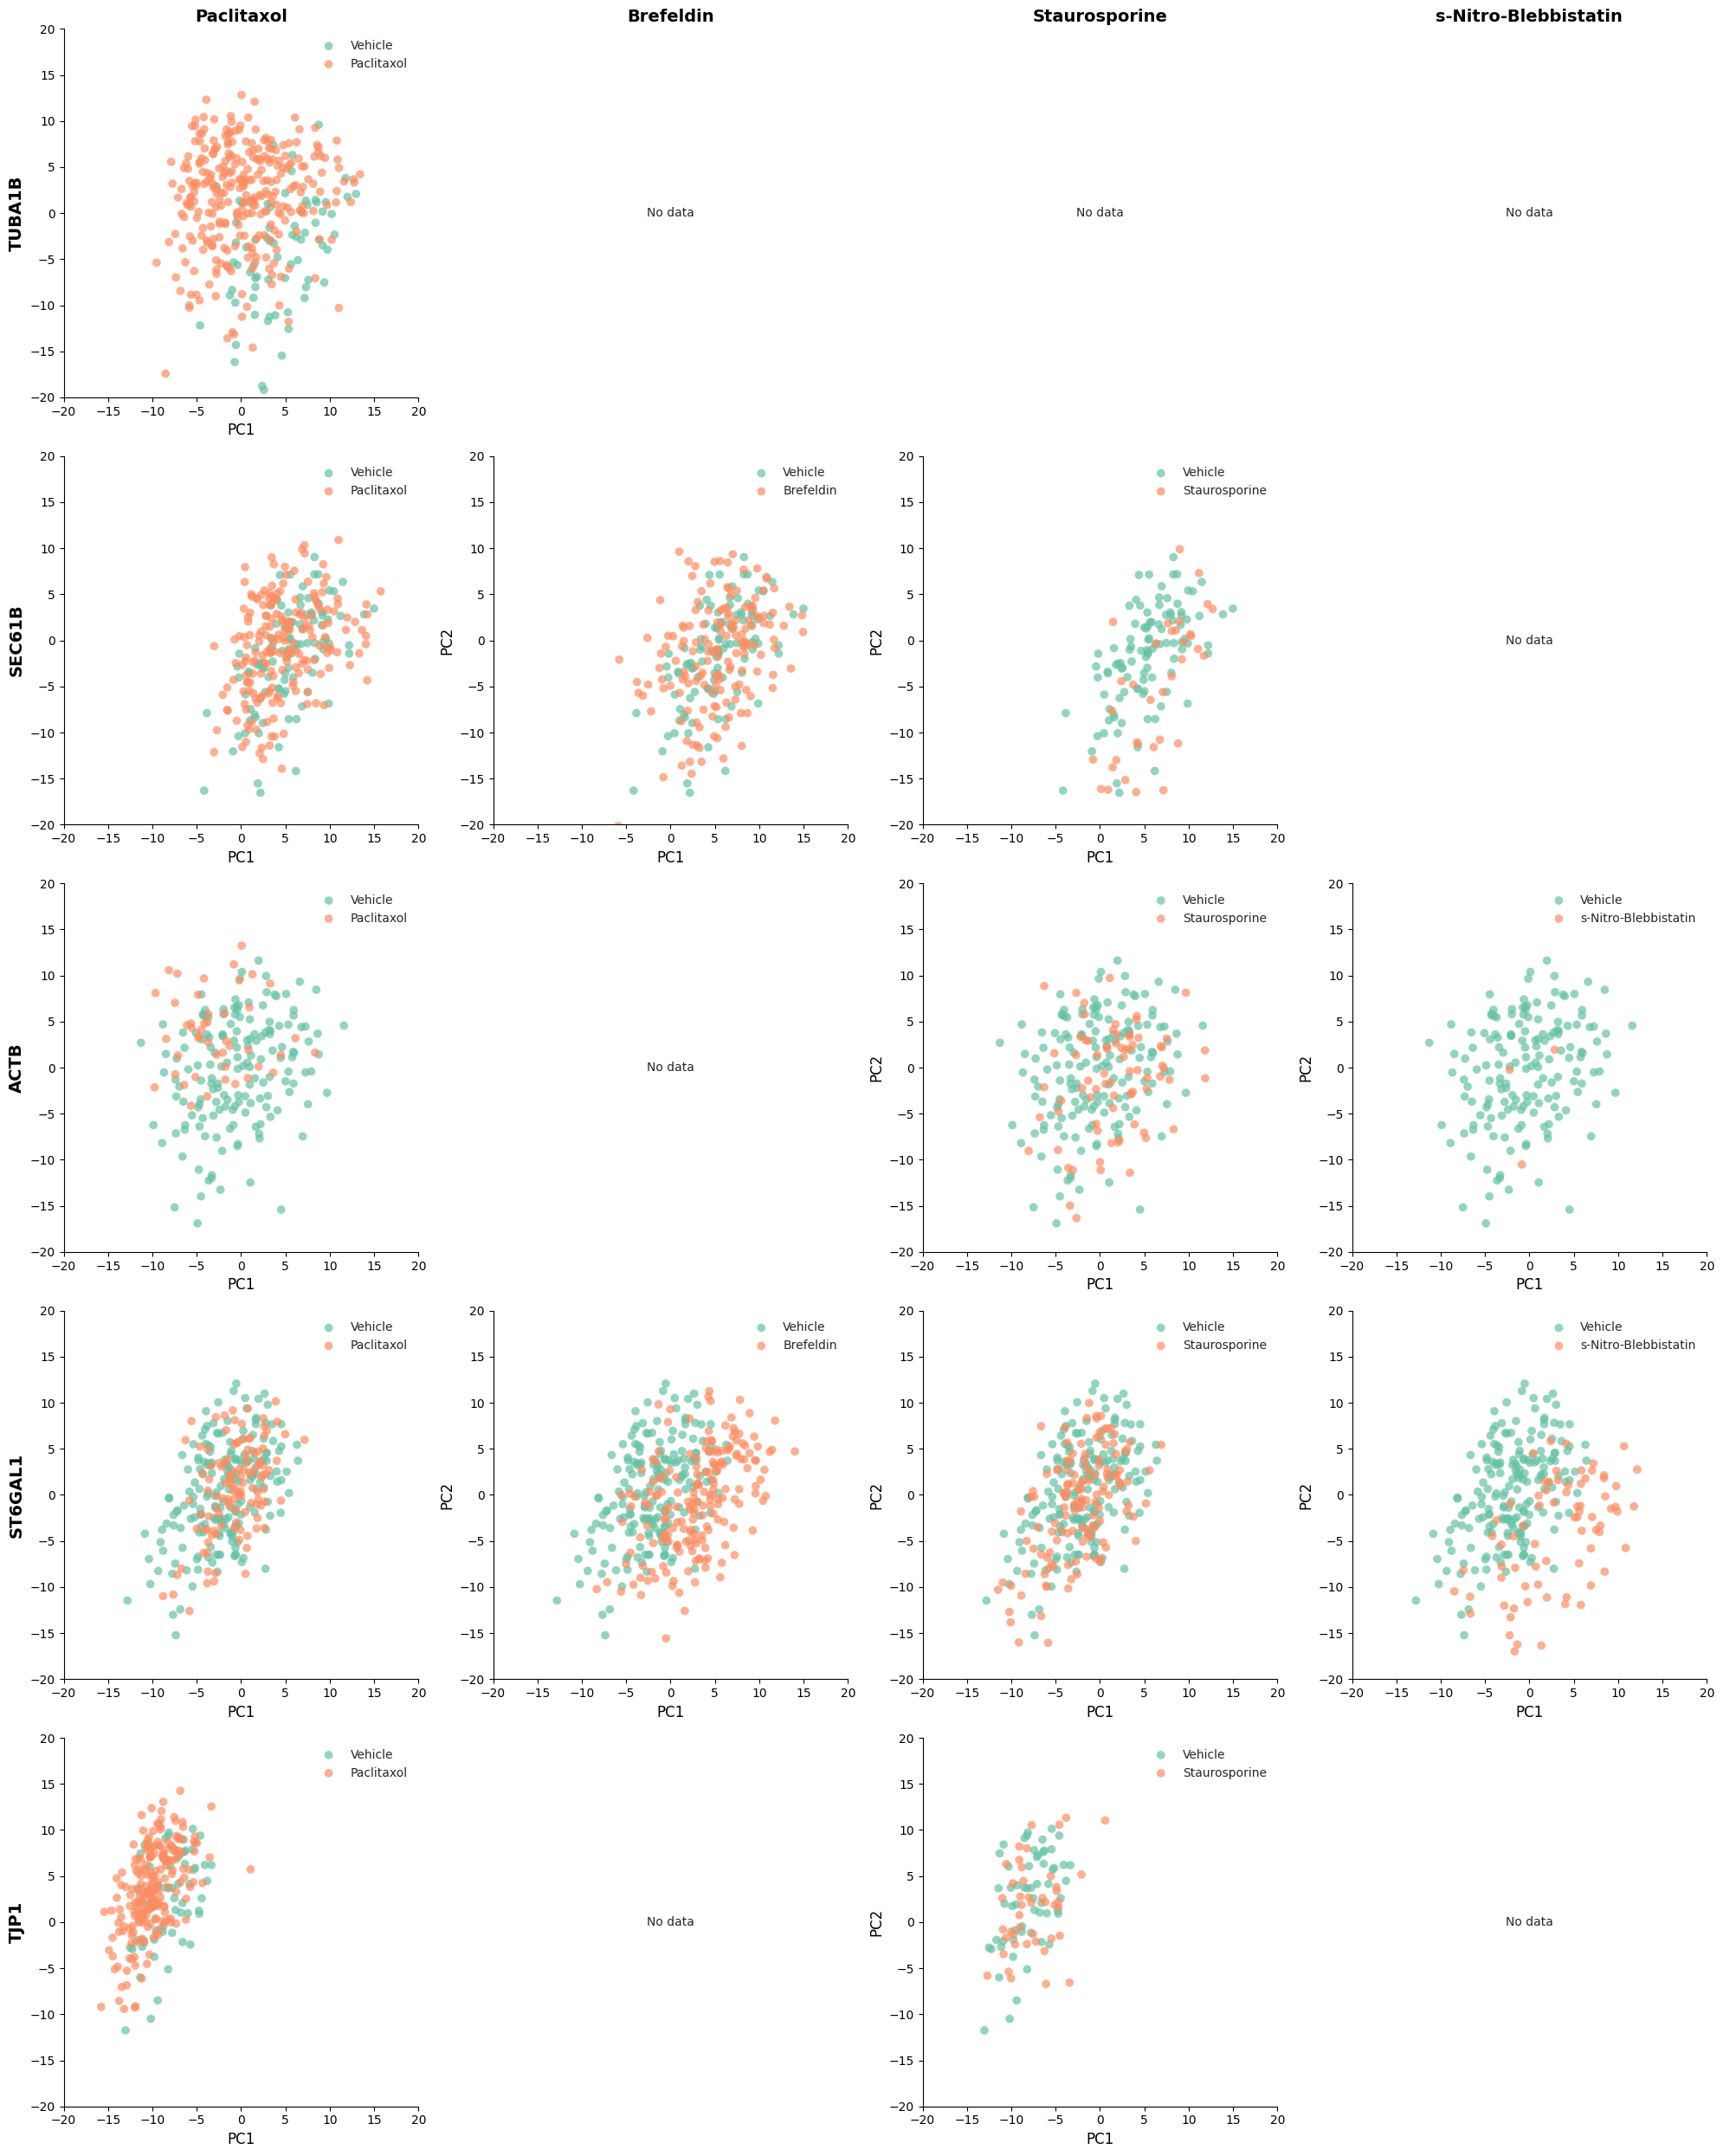

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_features():
    return pd.read_csv(WORKING_DIR/'assets/features/predictions.csv')

def get_feature_columns():
    return [str(i) for i in range(256)]

def visualize_treatments(pcs, df):
    genes = df.Gene.unique()
    drugs = [d for d in df.drug_label.unique() if d != 'Vehicle']
    
    n_rows, n_cols = len(genes), len(drugs)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), squeeze=False)
    
    # Set a cohesive style
    plt.style.use('seaborn-v0_8')
    colors = plt.cm.Set2(np.linspace(0, 1, 8))
    
    for i, gene in enumerate(genes):
        for j, drug in enumerate(drugs):
            ax = axes[i, j]
            
            # Set titles and labels
            if i == 0:
                ax.set_title(drug, fontsize=14, fontweight='bold')
            if j == 0:
                ax.set_ylabel(gene, fontsize=14, fontweight='bold')
            
            drug_idx = (df.Gene == gene) & (df.drug_label == drug)
            veh_idx = (df.Gene == gene) & (df.drug_label == 'Vehicle')
            
            if drug_idx.sum() > 0:
                ax.scatter(pcs[veh_idx, 0], pcs[veh_idx, 1], c=[colors[0]], label='Vehicle', alpha=0.7, edgecolors='none')
                ax.scatter(pcs[drug_idx, 0], pcs[drug_idx, 1], c=[colors[1]], label=drug, alpha=0.7, edgecolors='none')
                ax.set_xlim(-20, 20)
                ax.set_ylim(-20, 20)
                ax.legend(fontsize=10)
                ax.set_xlabel('PC1', fontsize=12)
                if j > 0:
                    ax.set_ylabel('PC2', fontsize=12)
                
                # Remove top and right spines
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
    
    plt.tight_layout()
    return fig

# Load and process data
features = load_features()
feat_cols = get_feature_columns()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

pcs = pipeline.fit_transform(features[feat_cols])
print('Explained variance ratio:', pipeline.named_steps['pca'].explained_variance_ratio_)

# Create and display the visualization
fig = visualize_treatments(pcs, features)
plt.show()

While the drug and vehicle distributions are highly overlapping for most cell line / drug combinations, a few interactions stand out as having a clear effect on the distribution of features: Tubulin and Paclitaxol, Golgi and Brefeldin, and Golgi and s-Nitro-Blebbistatin. To better understand the morphological changes that these drugs induce, we can find the axis that best separates the two distributions in PC space and visualize the cells along this axis.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from bioio.bio_image import imread
from tqdm import tqdm

def visualize_LDA(df, pcs, gene, drug, scale_low=20, scale_high=10):
    # Set style
    plt.style.use('seaborn-v0_8')
    colors = plt.cm.Set2(np.linspace(0, 1, 8))

    # Find indices in dataframe for gene and drug/vehicle
    veh_idx = (df.Gene == gene) & (df.drug_label == 'Vehicle')
    drug_idx = (df.Gene == gene) & (df.drug_label == drug)

    # Apply indices to pcs
    veh_pcs = pcs[veh_idx]
    drug_pcs = pcs[drug_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # PCA Projection plot
    ax1.scatter(veh_pcs[:, 0], veh_pcs[:, 1], c=[colors[0]], label='Vehicle', alpha=0.7, edgecolors='none')
    ax1.scatter(drug_pcs[:, 0], drug_pcs[:, 1], c=[colors[1]], label=drug, alpha=0.7, edgecolors='none')

    # Fit LDA
    X = np.concatenate([veh_pcs, drug_pcs])
    y = np.concatenate([np.zeros(veh_pcs.shape[0]), np.ones(drug_pcs.shape[0])])

    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X, y)
    lda_direction = lda.coef_[0]
    lda_line = np.array([-lda_direction*scale_low, lda_direction*scale_high])

    arrow_start = lda_line[0]
    arrow_end = lda_line[1]
    arrow_vector = arrow_end - arrow_start

    ax1.arrow(arrow_start[0], arrow_start[1], 
          arrow_vector[0], arrow_vector[1],
          color='r', width=0.2, head_width=1.0, head_length=1.0, 
          length_includes_head=True, label='LDA direction')
    ax1.set_xlabel('PC1', fontsize=12)
    ax1.set_ylabel('PC2', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.set_title('PCA Projection', fontsize=14, fontweight='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_aspect('equal')

    # LDA Projection plot
    ax2.hist(X_lda[y == 0], bins=50, color=colors[0], density=True, label='Vehicle', alpha=0.5)
    ax2.hist(X_lda[y == 1], bins=50, color=colors[1], density=True, label=drug, alpha=0.5)
    ax2.set_xlabel('LDA Coordinates', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.set_title('LDA Projection', fontsize=14, fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    return lda_line

def visualize_latent_walk(walk, df, feats, drug, gene, path_column='path'):
    # Extract drug and gene rows
    idx = (df.Gene == gene) & (df.drug_label.isin([drug, 'Vehicle']))
    df = df[idx]
    feats = feats[idx]
    
    movie = []
    # Find 4 closest examples at each point along walk
    for w in tqdm(walk, desc='Traversing PC-LDA line'):
        dist = np.linalg.norm(feats - w, axis=1)
        dist_argsort = np.argsort(dist)
        examples = []
        for idx in dist_argsort[:4]:
            img = imread(df.iloc[idx][path_column]).squeeze().max(0)
            examples.append(img)
        examples = np.vstack(examples)
        movie.append(examples)
    movie = np.hstack(movie)

    # Plot movie
    plt.figure(figsize=(20, 5))
    plt.imshow(movie, cmap='gray')
    plt.axis('off')
    
    # Set xticks with coordinates in w
    plt.xticks(np.linspace(0, movie.shape[1], len(walk)), 
               labels=np.round(walk, 2), 
               rotation=45, ha='right')
    
    plt.xlabel('LDA coordinates', fontsize=12)
    plt.ylabel("Nearest Neighbors", fontsize=12)
    plt.title(f'{gene} x {drug} latent walk', fontsize=14, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(label='Pixel Intensity')
    
    plt.tight_layout()
    plt.show()

## Tubulin and Paclitaxol

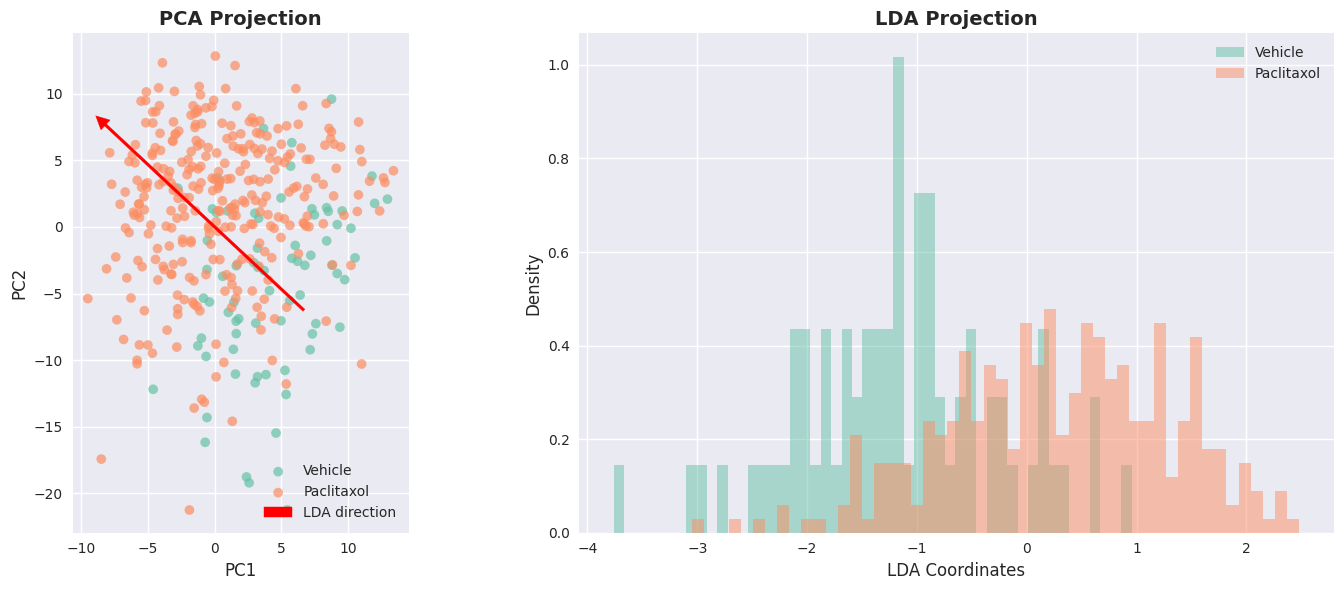

Traversing PC-LDA line: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


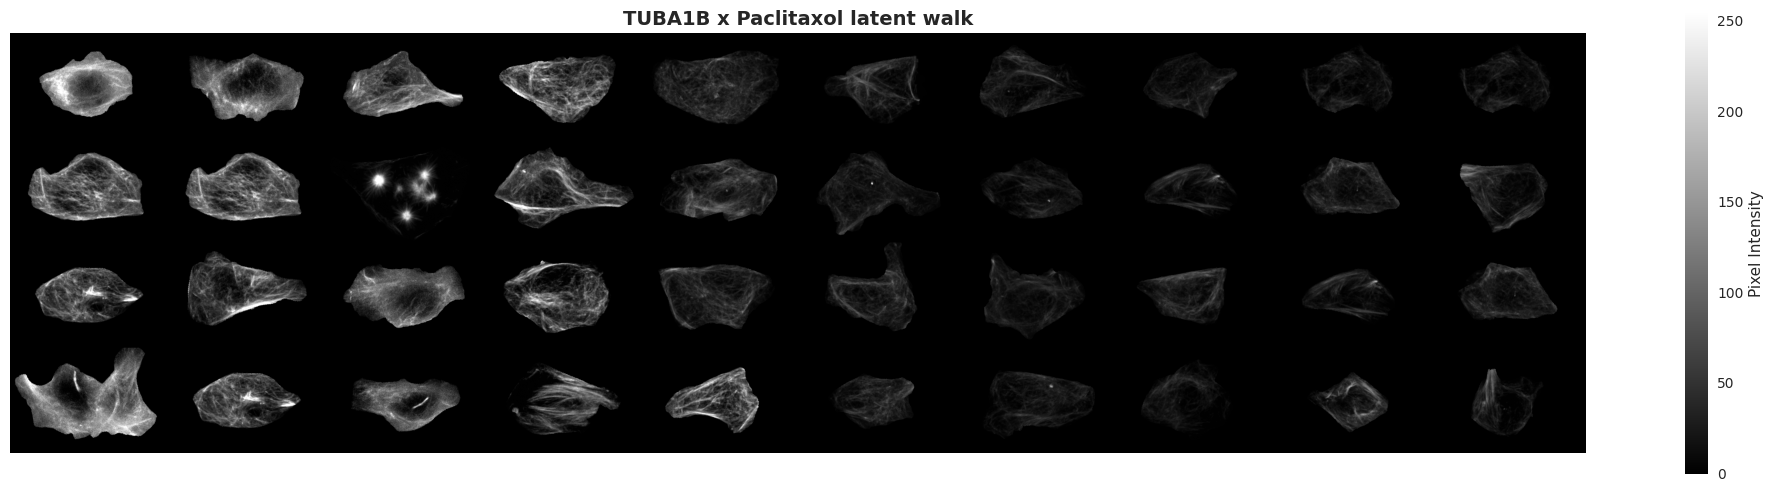

In [6]:
drug = 'Paclitaxol'
gene = 'TUBA1B'

lda_line = visualize_LDA(features,pcs, gene, drug, scale_low=30, scale_high=40)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

Traversing the LDA line shows a marked decrease in intensity as we move from Paclitaxol-treated cells to Vehicle-treated cells. In addition, the distribution of tubulin seems to change - the Paclitaxol-treated cells have very bright bundles of tubulin, while vehicle-treated cells have more diffuse, uniform tubulin.

## Golgi and Brefeldin

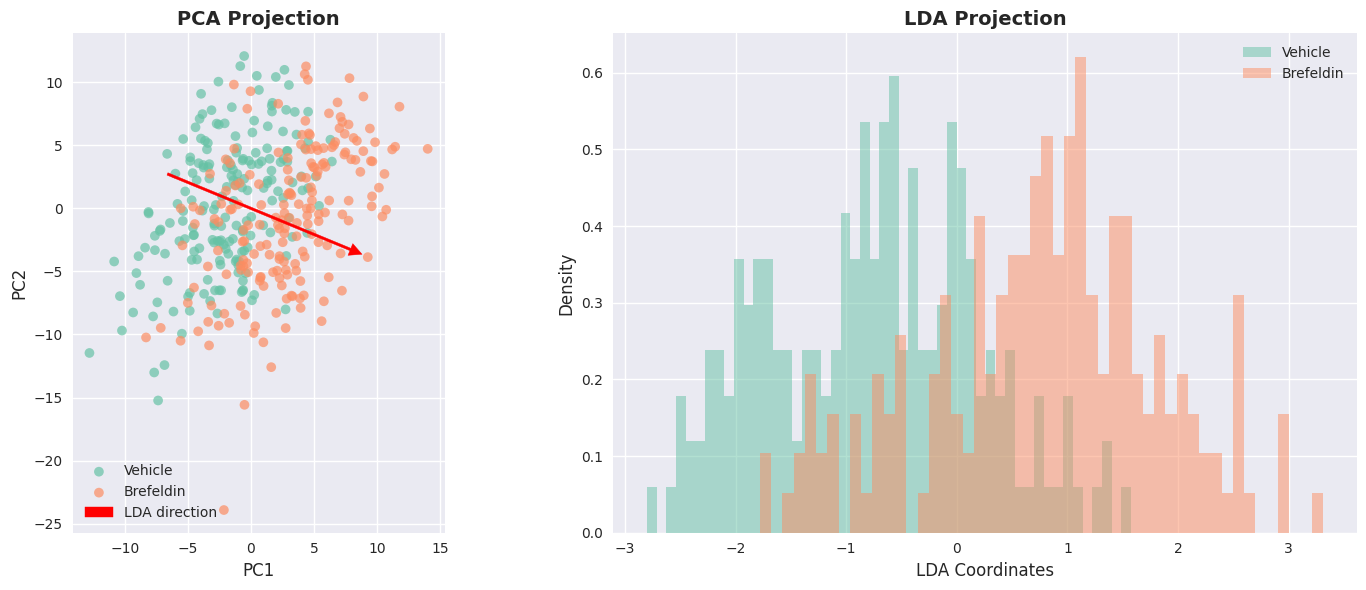

Traversing PC-LDA line: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


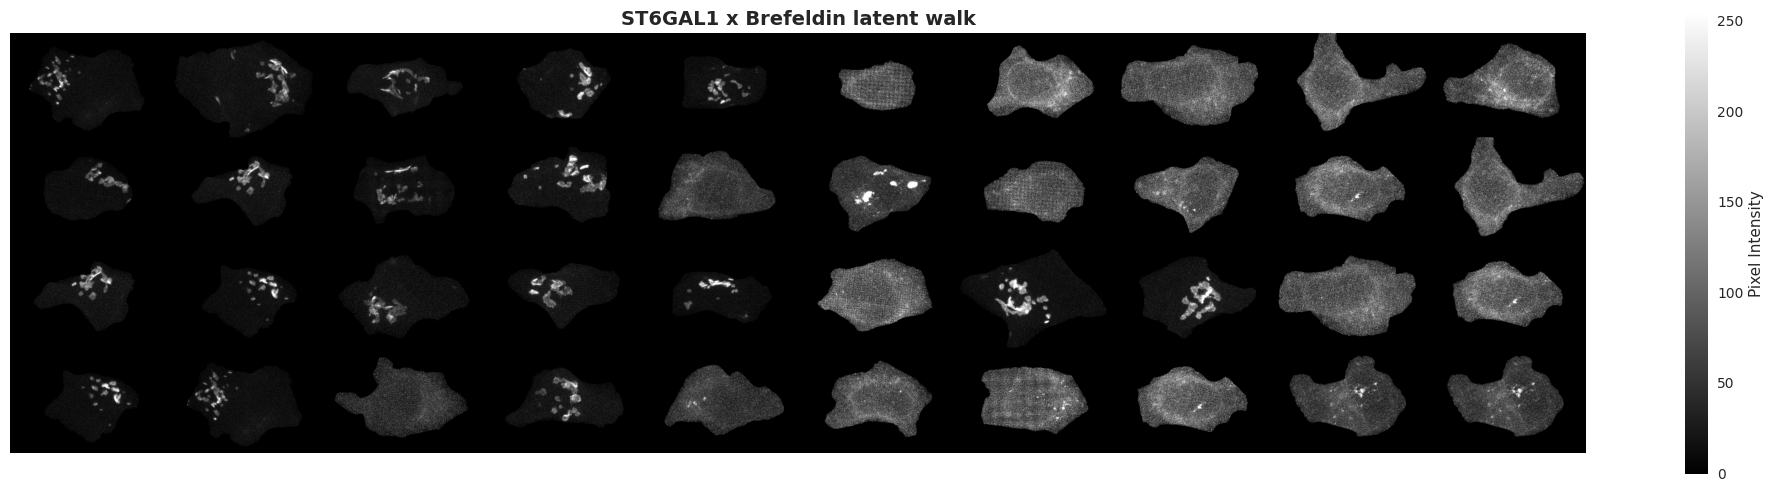

In [7]:
drug = 'Brefeldin'
gene = 'ST6GAL1'

lda_line = visualize_LDA(features, pcs, gene, drug, scale_low=15, scale_high=20)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

With Brefeldin-treated cells, we again see a significant change in Golgi distribution, with Brefeldin-treated cells having a distinct,diffuse Golgi distribution. Brefeldin is known to cause disassembly of the Golgi apparatus, and this is reflected in the features of our model as the primary difference between the drug- and vehicle-treated cells.

## Golgi and s-Nitro-Blebbistatin

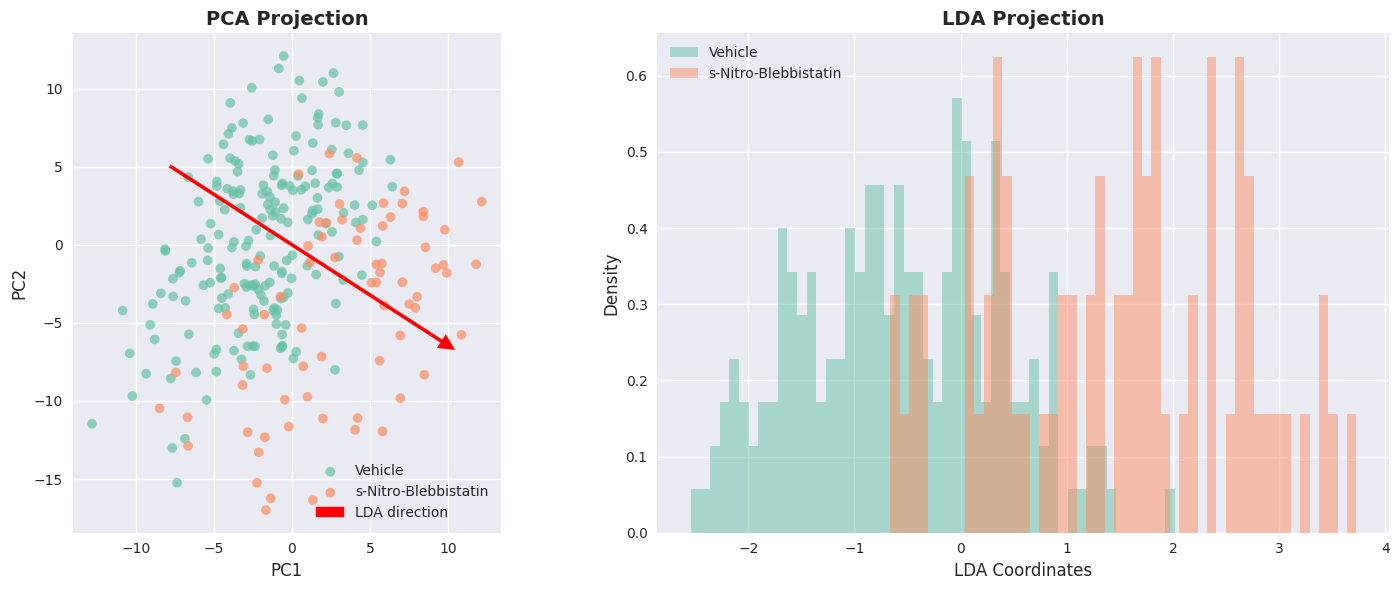

Traversing PC-LDA line: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


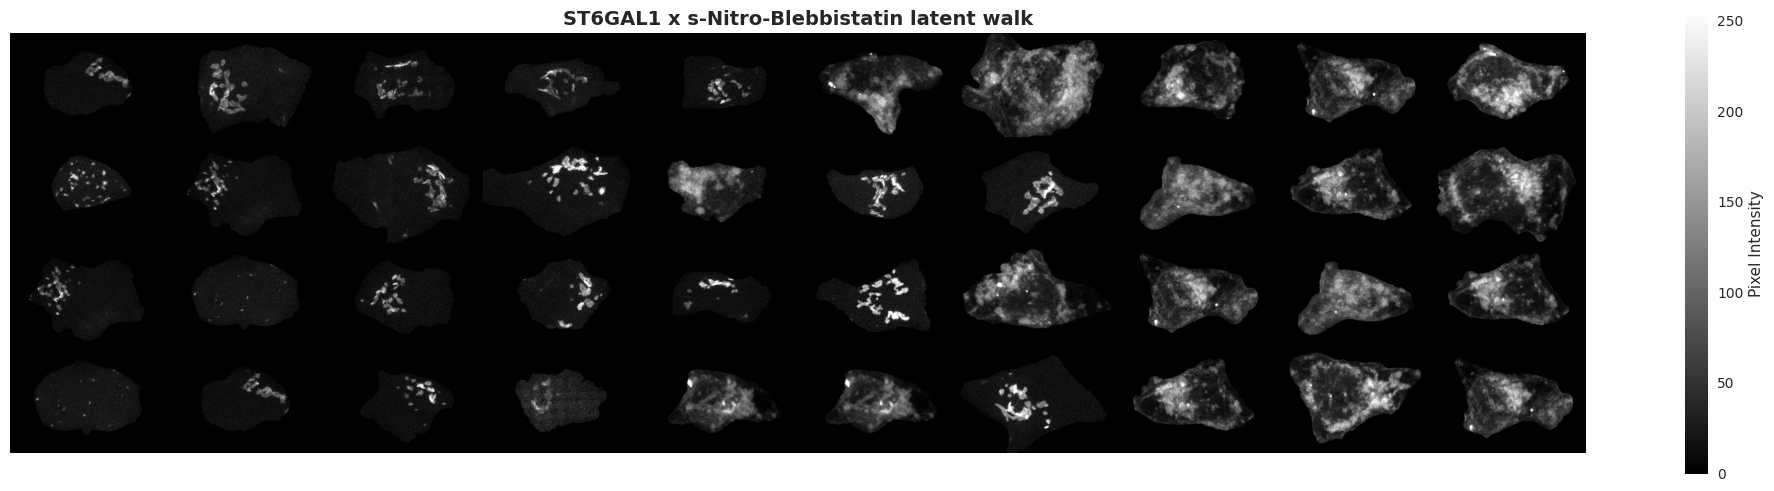

In [8]:
drug = 's-Nitro-Blebbistatin'
gene = 'ST6GAL1'

lda_line = visualize_LDA(features, pcs, gene, drug, scale_low=15, scale_high=20)
visualize_latent_walk(np.linspace(lda_line[0], lda_line[1], 10), features, pcs, drug, gene)

s-Nitro-Blebbistatin treatment causes a similar dissolution of the Golgi apparatus, from clusters of puncta to a diffuse and blobby morphology. 